In [61]:
# import library + read binary image function
import cv2
import matplotlib.pyplot as plt
import numpy as np

def read_bin_img(file_path, width=256, height=256, chanel=1):
    data = None
    with open(file_path, 'rb') as file:
        data = file.read()
    data = np.frombuffer(data, dtype=np.uint8)
    return (np.reshape(data, (width, height, chanel))) if (chanel > 1) else (np.reshape(data, (width, height)))

2.1

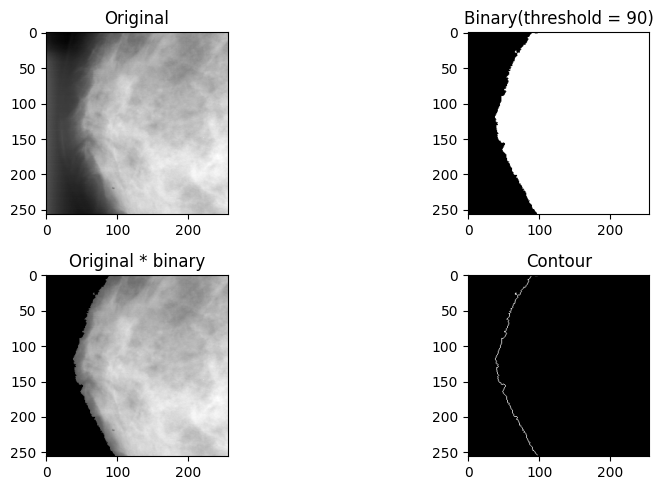

In [62]:
img = read_bin_img("Mammogram.bin")

threshold = 90
bin_img = img > threshold

contour = np.zeros(bin_img.shape, np.uint8)
for i in range(1, contour.shape[0]-1):
    for j in range(1, contour.shape[1]-1):
        if (bin_img[i][j] == 1)and(bin_img[i+1][j] == 0 or
                bin_img[i-1][j] == 0 or
                bin_img[i][j+1] == 0 or
                bin_img[i][j-1] == 0):
            contour[i][j] = 1

plt.figure("Homework 2.1", (10, 5))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")

plt.subplot(2, 2, 2)
plt.imshow(bin_img, cmap='gray', vmin=0, vmax=1)
plt.title(f"Binary(threshold = {threshold})")

plt.subplot(2, 2, 3)
plt.imshow(bin_img * img, cmap='gray')
plt.title("Original * binary")

plt.subplot(2, 2, 4)
plt.imshow(contour, cmap='gray')
plt.title("Contour")

plt.tight_layout()
plt.show()

2.2

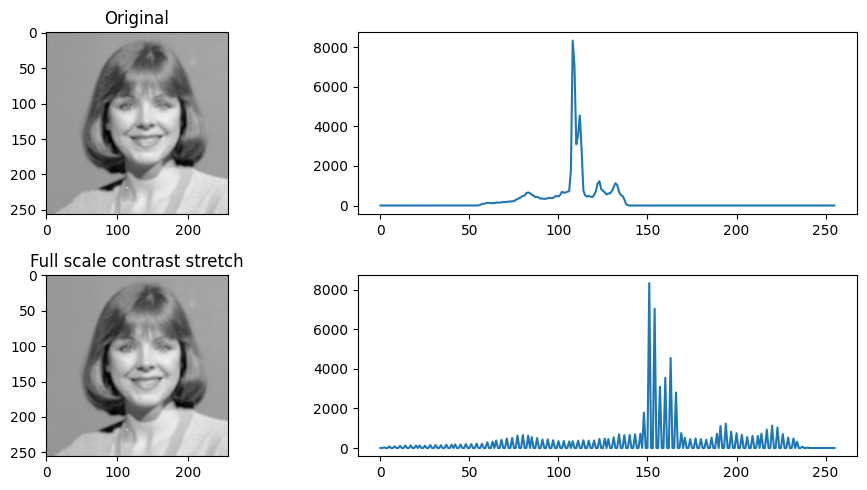

In [63]:
# original
img = read_bin_img('lady.bin')
colors = [_ for _ in range(256)]
colors_count = [np.sum(img == _) for _ in range(256)]

# full scale contrast stretch
min_color = np.min(img).astype(np.uint8)
max_color = np.max(img).astype(np.uint8)
scaled_img = np.copy(img)
scaled_img = ((scaled_img - min_color)/(max_color - min_color)) * 255
scaled_img = scaled_img.astype(np.uint8)
scaled_color_count = [np.sum(scaled_img == _) for _ in range(256)]

# plot
plt.figure("Homework 2.2", (10, 5))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")

plt.subplot(2, 2, 2)
plt.plot(colors, colors_count)

plt.subplot(2, 2, 3)
plt.imshow(scaled_img, cmap='gray')
plt.title("Full scale contrast stretch")

plt.subplot(2, 2, 4)
plt.plot(colors, scaled_color_count)

plt.tight_layout()

2.3

Found 9 points
  y    x    number of pixels match
---  ---  ------------------------
112   69                       346
112   70                       340
113   69                       355
113   70                       348
113  141                       350
113  142                       355
114   69                       343
114  141                       341
114  142                       344

Choose best match of each group:
  y    x    number of pixels match
---  ---  ------------------------
113   69                       355
113  142                       355


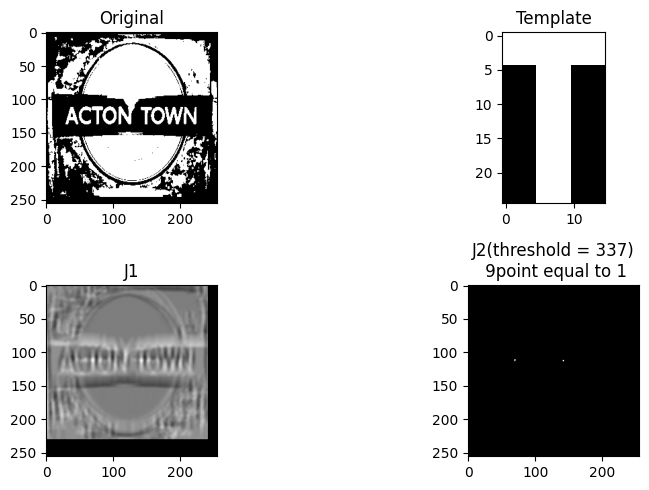

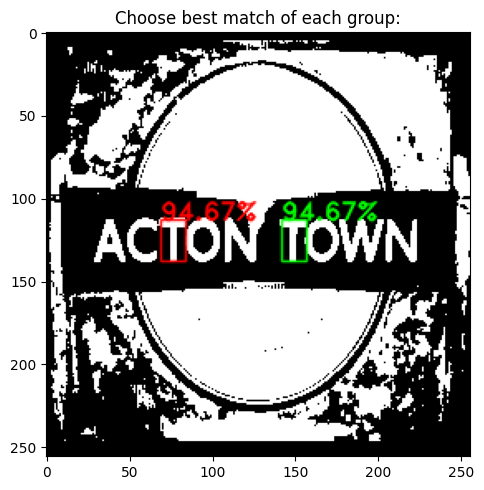

In [64]:
img = read_bin_img('actontBin.bin')

# template
template = np.zeros((25, 15), np.uint8)
template[0:5, :] = 255
template[0:, 5:10] = 255

# make J1
def match_count(source, temp, pos):
    """
    pos: top-left position in source [row, column]
    """
    h, w = temp.shape
    window = source[pos[0]:(pos[0] + h), pos[1]:(pos[1]+w)]
    return np.sum(window == temp).astype(np.uint32)

J1 = np.zeros_like(img, np.uint32)
for i in range(0, img.shape[0]-template.shape[0]):
    for j in range(0, img.shape[1]-template.shape[1]):
        J1[i][j] = match_count(img, template, (i, j))

# make J2
# threshold: >= 90 % pixel match
threshold = int(0.9 * template.shape[0]*template.shape[1])
J2 = J1 >= threshold


plt.figure("Homework 2.3", (10, 5))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")

plt.subplot(2, 2, 2)
plt.imshow(template, cmap='gray')
plt.title(f"Template")

plt.subplot(2, 2, 3)
plt.imshow(J1, cmap='gray')
plt.title("J1")

plt.subplot(2, 2, 4)
plt.imshow(J2, cmap='gray')
plt.title(f"J2(threshold = {threshold})\n {np.sum(J2 == 1)}point equal to 1")
plt.tight_layout()


# choose best match
ys, xs = np.where(J2 == 1)
points = list(zip(ys, xs))
points = [(p[0], p[1], J1[p[0], p[1]]) for p in points]
print(f"Found {len(points)} point{'s' if (len(points)>1) else ''}")

from tabulate import  tabulate
print(tabulate(points, headers=["y", "x", "number of pixels match"]))

i = 0
while i < len(points):
    j = i+1
    while j < len(points):

        if (abs(points[i][0] - points[j][0]) < template.shape[0]) and\
            (abs(points[i][1] - points[j][1]) < template.shape[1]) :
            if J1[points[i][0], points[i][1]] < J1[points[j][0], points[j][1]]:
                points.pop(i)
                i -= 1
                break
            else:
                points.pop(j)
                j-=1
        j += 1
    i += 1

print("\nChoose best match of each group:")
print(tabulate(points, headers=["y", "x", "number of pixels match"]))
best_match_points_img = cv2.cvtColor(np.copy(img), cv2.COLOR_GRAY2RGB)
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
c_idx = 0
for p in points:
    color = colors[c_idx]
    c_idx = (c_idx+1)%len(colors)

    pt1 = (p[1], p[0])
    pt2 = (p[1] + template.shape[1], p[0]+template.shape[0])
    cv2.rectangle(best_match_points_img, pt1, pt2, color, 1, cv2.LINE_AA)

    text = f"{ (J1[p[0], p[1]]/(template.shape[0]*template.shape[1]))*100:.02f}%"
    cv2.putText(best_match_points_img, text, pt1, cv2.FONT_HERSHEY_DUPLEX,1/2, color, 1, cv2.LINE_AA)


plt.figure("hi", (10, 5))
plt.imshow(best_match_points_img)
plt.title("Choose best match of each group:")

plt.tight_layout()


2.4

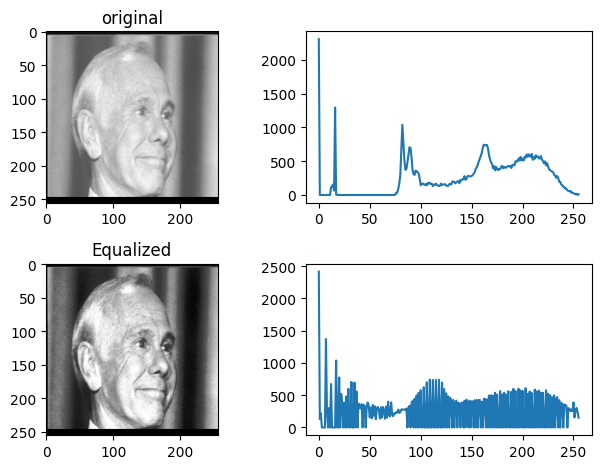

In [65]:
# original
img = read_bin_img('johnny.bin')
colors = [_ for _ in range(256)]
colors_count = [np.sum(img == _)for _ in range(256)]

#equalization
equal_img = cv2.equalizeHist(img)
equal_color_count = [np.sum(equal_img == _) for _ in range(256)]

#plot
plt.figure("Homework 2.4")

plt.subplot(2, 2,1)
plt.imshow(img, cmap='gray')
plt.title("original")

plt.subplot(2, 2, 2)
plt.plot(colors, colors_count)

plt.subplot(2, 2, 3)
plt.imshow(equal_img, cmap='gray')
plt.title("Equalized")

plt.subplot(2, 2, 4)
plt.plot(colors, equal_color_count)
plt.tight_layout()